<h1>Testing the E2E simulations</h1>

This script introduces the end-to-end (E2E) simulations that are used in "**calibration.py**", for the influence calibration of each individual segment. The testing of the script itself is done in this next notebook.

In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import webbpsf

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util
import image_pastis as impastis

# Path to all the outputs from "aperture_definition.py".
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
# Change into that directory
os.chdir(dir)

os.environ['WEBBPSF_PATH'] = CONFIG_INI.get('local', 'webbpsf_data_path')

In [34]:
# Get some parameters
fpm = CONFIG_INI.get('coronagraph', 'focal_plane_mask')         # focal plane mask
lyot_stop = CONFIG_INI.get('coronagraph', 'pupil_plane_stop')   # Lyot stop
filter = CONFIG_INI.get('filter', 'name')                       # filter
im_size = CONFIG_INI.getint('numerical', 'im_size_px')          # image size in pixels
wss_segs = webbpsf.constants.SEGNAMES_WSS_ORDER
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')

nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')    # [nm] amplitude of aberration
zern_number = CONFIG_INI.getint('calibration', 'zernike')               # Which (Noll) Zernike we are calibrating for
wss_zern_nb = util.noll_to_wss(zern_number)                             # Convert from Noll to WSS framework

For starters, lets completely independently create some WebbPSF images of a direct image (no coronagraph) and a coronagraphic image.

In [5]:
# Create two NIRCam objects
nc = webbpsf.NIRCam()
nc_coro = webbpsf.NIRCam()

In [6]:
# Btw:
print('NIRCam pixelscale:', nc.pixelscale)
print('Telescope:', nc.telescope)
print('nc name:', nc.name)
print('NIRCam module used:', nc.module)
print('NIRCam list of image masks:', nc.image_mask_list)
print('NIRCam list of pupil masks:', nc.pupil_mask_list)
print('NIRCam currently used OPD:', nc.pupilopd)
print('NIRCam detector list:', nc.detector_list)
print('nc used detector:', nc.detector)
print('Pixel position in (X, Y) on the detector:', nc.detector_position)
print('NIRCam filter list:', nc.filter_list)
print('nc used filter:', nc.filter)
print('nc channel used:', nc.channel)


NIRCam pixelscale: 0.0311
Telescope: JWST
nc name: NIRCam
NIRCam module used: A
NIRCam list of image masks: ['MASKLWB', 'MASKSWB', 'MASK210R', 'MASK335R', 'MASK430R']
NIRCam list of pupil masks: ['CIRCLYOT', 'WEDGELYOT', 'MASKRND', 'MASKSWB', 'MASKLWB', 'WEAK LENS +4', 'WEAK LENS +8', 'WEAK LENS -8', 'WEAK LENS +12 (=4+8)', 'WEAK LENS -4 (=4-8)', 'WLP4', 'WLM4', 'WLP8', 'WLM8', 'WLP12']
NIRCam currently used OPD: OPD_RevW_ote_for_NIRCam_requirements.fits.gz
NIRCam detector list: ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCA5', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4', 'NRCB5']
nc used detector: NRCA1
Pixel position in (X, Y) on the detector: (1024, 1024)
NIRCam filter list: ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']
nc used filter: F200W
nc channel used: short


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


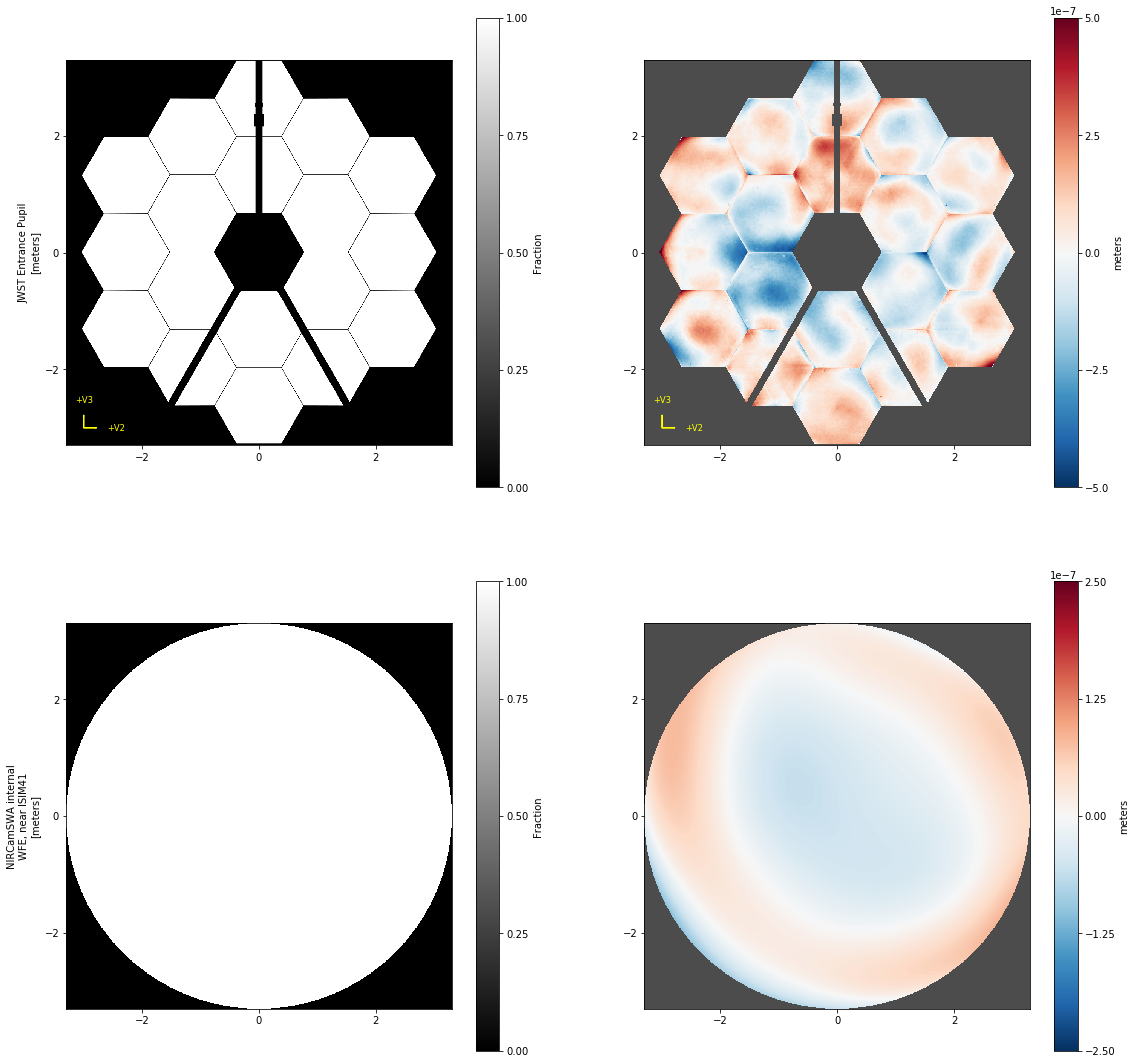

In [7]:
# Some displays
plt.figure(figsize=(19, 19))
nc.display()
plt.show()

#nc.calc_psf?
#nc.calcPSF?

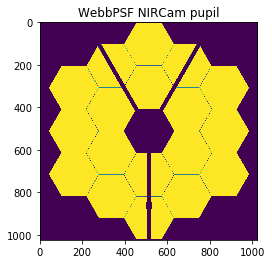

Pupil shape: (1024, 1024)


In [8]:
# Show the pupil used
nc_pup = fits.getdata(nc.pupil)
plt.imshow(nc_pup)
plt.title('WebbPSF NIRCam pupil')
plt.show()

print('Pupil shape:', nc_pup.shape)

In [9]:
# Null the OTE OPDs for the PSFs, internal WFE stays though.
nc, ote = webbpsf.enable_adjustable_ote(nc)                     # create OTE for default PSF
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)      # create OTE for coronagraph
ote.zero()          # set OTE for direct PSF to zero
ote_coro.zero()     # set OTE for coronagraph to zero

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


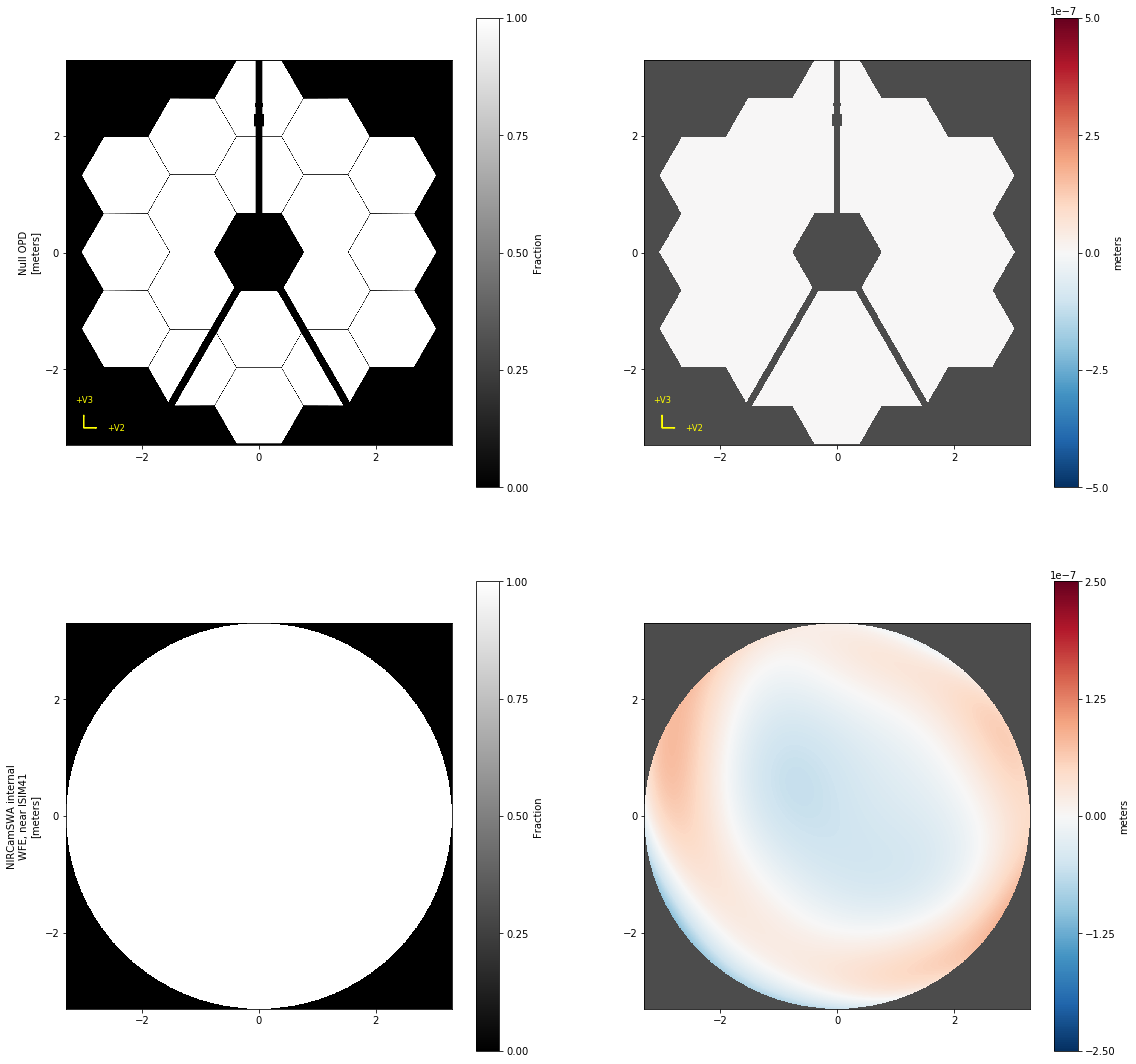

In [10]:
plt.figure(figsize=(19, 19))
nc.display()
plt.show()

From the WebbPSF turotial (https://github.com/mperrin/webbpsf/blob/master/notebooks/WebbPSF_tutorial.ipynb) we know that calc_psf() calculates images with different sampling (I think I also explain this in my notebook "DealingWithWebbPSF.ipynb") and we can access them in the different HDU extensions.

In that same notebook, I also explain why I use oversample=1 and nlambda=1 to make the calculations faster.

## NO CORONAGRAPH

### Generating a direct PSF

In [11]:
# Let's see what the current direct PSF looks like (coronagraphic PSF is the same since they've been set up the same
# and I haven't added the coronagraph yet)
psf_direct_hdu = nc.calc_psf(oversample=1, nlambda=1)

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


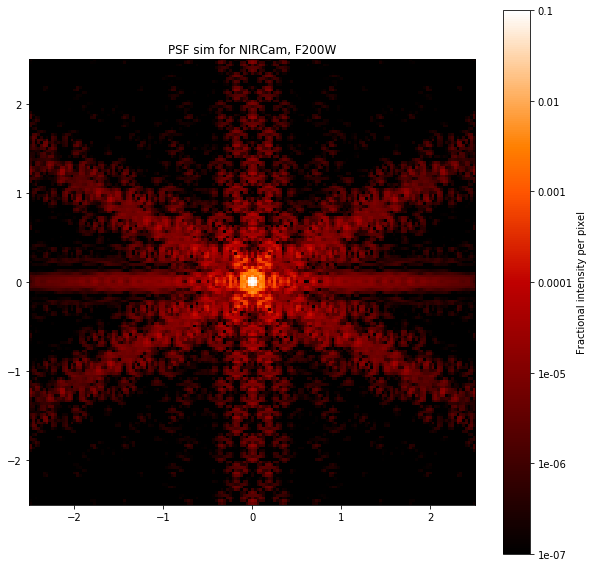

In [13]:
# Display by WebbPSF
plt.figure(figsize=(10,10))
webbpsf.display_psf(psf_direct_hdu)
plt.show()

PSF shape: (161, 161)


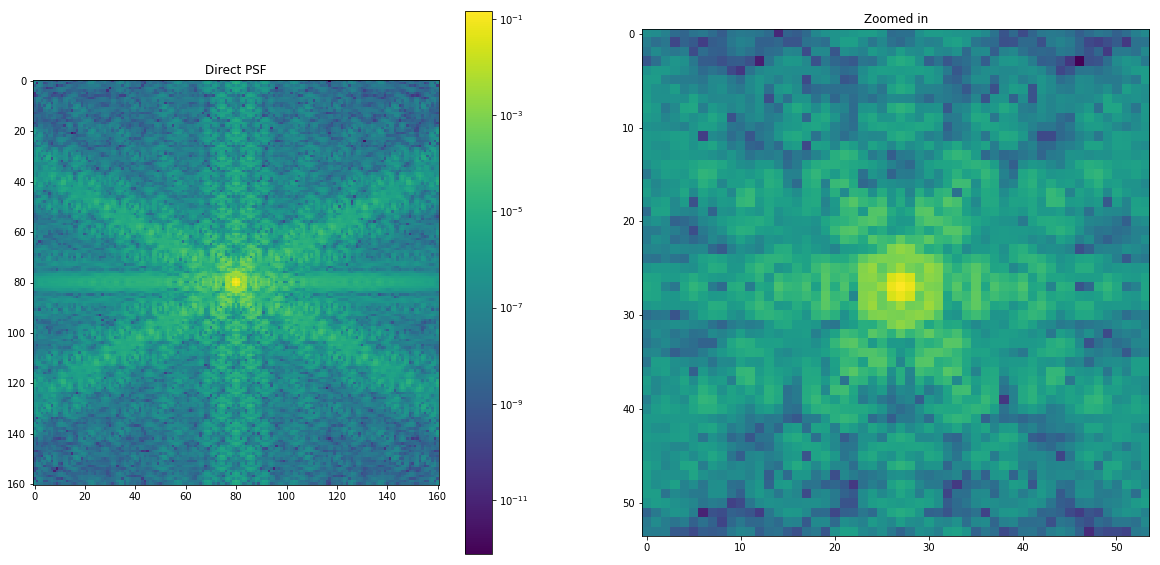

In [18]:
# Display with matplotlib
psf_direct = psf_direct_hdu[1].data
print('PSF shape:', psf_direct.shape)

xcen = int(psf_direct.shape[1]/2)
ycen = int(psf_direct.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(psf_direct, norm=LogNorm())
plt.title('Direct PSF')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_direct[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm())
plt.title('Zoomed in')
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


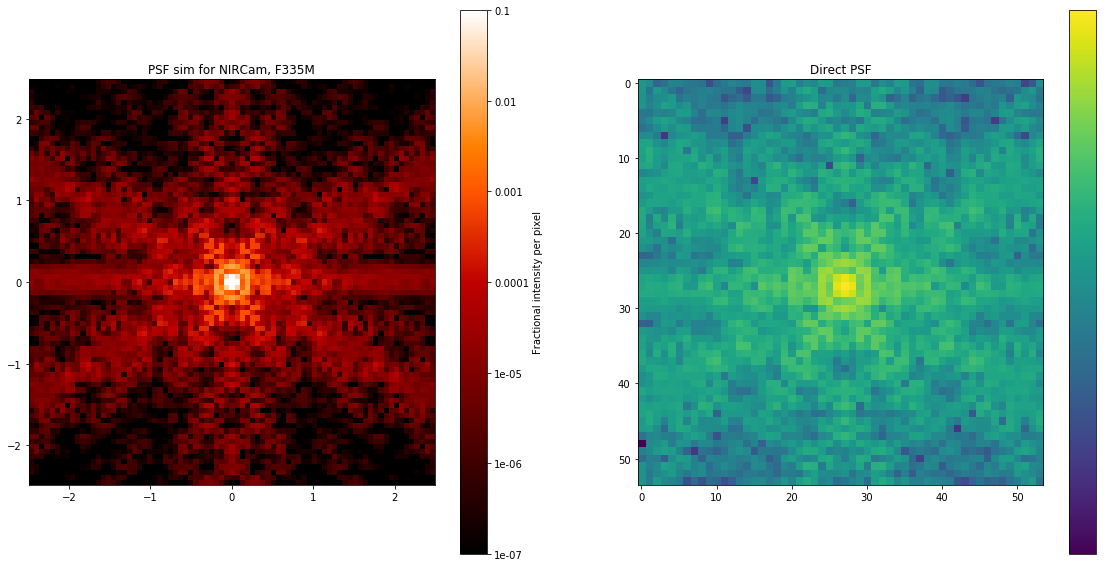

In [21]:
# Add the filter we want to use
nc.filter = filter
nc_coro.filter = filter

# So far both nc objects are still the same, so I'll display only one
psf = nc.calc_psf(oversample=1, nlambda=1)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
webbpsf.display_psf(psf)

psf = psf[1].data
xcen = int(psf.shape[1]/2)
ycen = int(psf.shape[0]/2)
boxhw = 27

plt.subplot(1, 2, 2)
plt.imshow(psf[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm())
plt.title('Direct PSF')
plt.colorbar()
plt.show()

We want our images to be the same size like our simulations, so we use "fov_pixels".

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


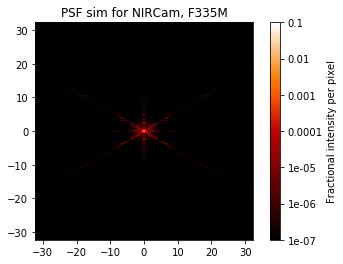

In [22]:
# Both nc (non-coro and coro) objects are still the same, so I'll display only one
psf = nc.calc_psf(fov_pixels=im_size, oversample=1, nlambda=1)
webbpsf.display_psf(psf)
plt.show()

psf = psf[1].data

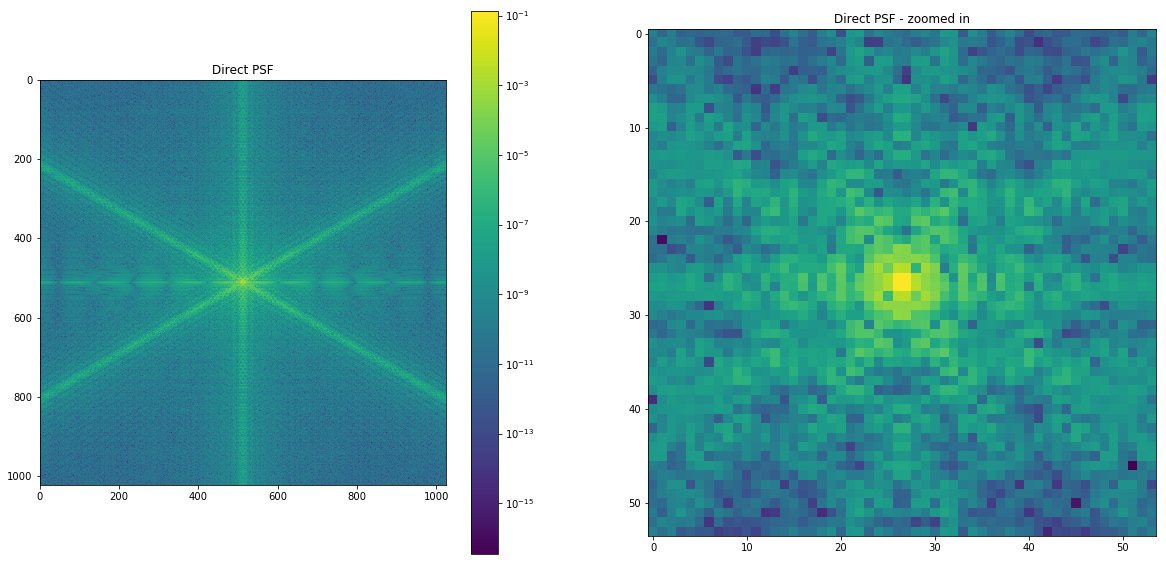

In [23]:
# Display with matplotlib
xcen = int(psf.shape[1]/2)
ycen = int(psf.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf, norm=LogNorm())
plt.title('Direct PSF')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm())
plt.title('Direct PSF - zoomed in')
plt.show()

### A single aberrated segment

To compare to the analytical images step by step, I will first create images with only one segment aberrated.

In [77]:
segnum = 5     # Which segment are we aberrating - I number them starting with 1
segnum -= 1    # Which is why I have to subtract one, because WebbPSF starts numbering them at 0
# Extract the correct segment name from WebbPSF
seg = wss_segs[segnum].split('-')[0]
print('Aberrated segment:', seg)

Aberrated segment: A5


In [78]:
# Create arrays to hold Zernike aberration coefficients
Aber_WSS = np.zeros([nb_seg, zern_max])           # The Zernikes here will be filled in the WSS order!!!
                                                  # Because it goes into _apply_hexikes_to_seg().
Aber_Noll = np.copy(Aber_WSS)                     # This is the Noll version for later.

# Feed the aberration nm_aber into the array position
# that corresponds to the correct Zernike, but only on segment i
Aber_WSS[segnum, wss_zern_nb-1] = nm_aber / 1e9        # Aberration on the segment we're currently working on;
                                                  # convert to meters; -1 on the Zernike because Python starts
                                                  # numbering at 0.
Aber_Noll[segnum, zern_number-1] = nm_aber             # Noll version - in nm!

#-# Crate OPD with aberrated segment, NO CORONAGRAPH
print('Applying aberration to OTE.')
ote.reset()   # Making sure there are no previous movements on the segments.
ote.zero()    # For now, ignore internal WFE.
ote._apply_hexikes_to_seg(seg, Aber_WSS[segnum,:])

Applying aberration to OTE.


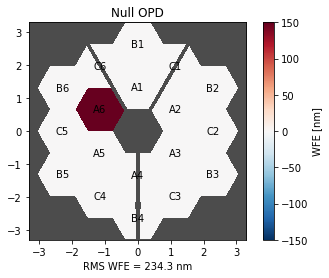

In [79]:
# Display the OTE
ote.display_opd()
plt.show()
# At this point, WebbPSF still numbers the segments wrong in the exit pupil,
# so it's the easiest to orient yourself by the spiders.

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


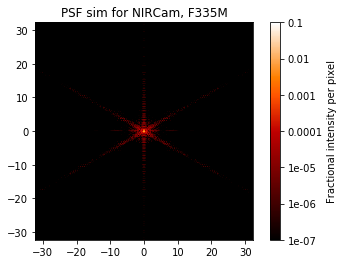

In [47]:
# Calculate the PSF
psf_minizern = nc.calc_psf(fov_pixels=im_size, oversample=1, nlambda=1)
webbpsf.display_psf(psf_minizern)
plt.show()

psf_minizern = psf_minizern[1].data

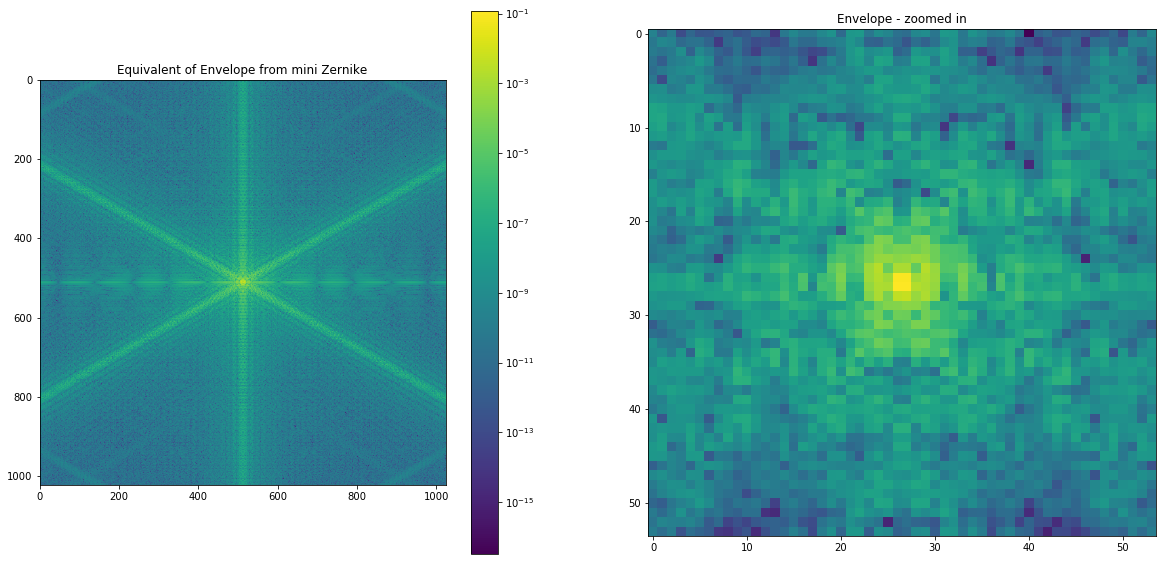

In [49]:
# Display with matplotlib
xcen = int(psf_minizern.shape[1]/2)
ycen = int(psf_minizern.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf_minizern, norm=LogNorm())
plt.title('Equivalent of Envelope from mini Zernike')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_minizern[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm())
plt.title('Envelope - zoomed in')
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


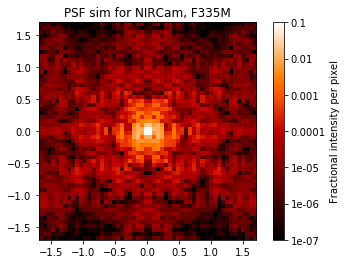

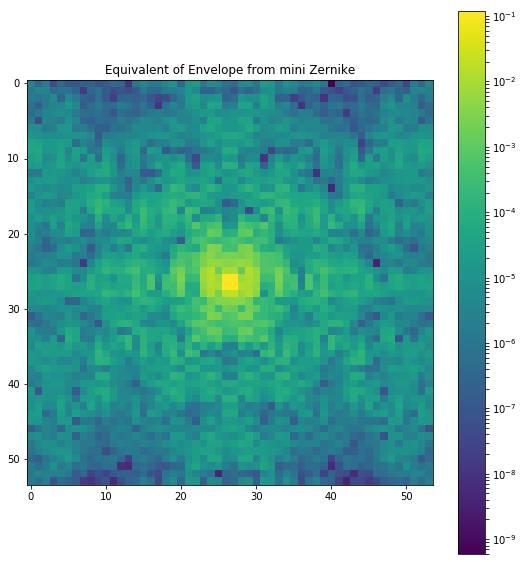

In [52]:
# Repeat on a smaller image direclty instead of cropping it afterwards, for faster computation
# Calculate the PSF
psf_minizern = nc.calc_psf(fov_pixels=54, oversample=1, nlambda=1)
webbpsf.display_psf(psf_minizern)
plt.show()

psf_minizern = psf_minizern[1].data

# Display with matplotlib
xcen = int(psf_minizern.shape[1]/2)
ycen = int(psf_minizern.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf_minizern, norm=LogNorm())
plt.title('Equivalent of Envelope from mini Zernike')
plt.colorbar()
plt.show()

In [71]:
"""
# Make a loop over the first eight Zernike envelopes, like in notebook 2
aber_wss_loop = np.zeros([nb_seg, 8])
psfs_env = []
plt.figure(figsize=(18, 60))
plt.suptitle('Different Zernikes envelopes from WebbPSF')
noll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use
print('nm_aber:', nm_aber, 'nm')

for i, zern in enumerate(noll_as_wss):
    
    # Put the Zernike coefficient in correct place in
    aber_wss_loop[:,:] = 0     # set all entries to zero
    aber_wss_loop[segnum, zern-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters
    #print(aber_wss_loop[segnum, :])
    
    # Put Zernike on correct segment on OTE
    ote.reset()   # Making sure there are no previous movements on the segments.
    ote.zero()    # For now, ignore internal WFE.
    ote._apply_hexikes_to_seg(seg, aber_wss_loop[segnum,:])
    
    # Display the OTE
    plt.subplot(8, 2, i*2+1)
    ote.display_opd()
    
    # Calculate the PSF
    print('Calculating PSF', str(i+1) + '/' + '8')
    psf_zernloop = nc.calc_psf(fov_pixels=54, oversample=1, nlambda=1)
    psf_zernloop = psf_zernloop[1].data
    psfs_env.append(psf_zernloop)
    
    # Display the PSF
    plt.subplot(8, 2, i*2+2)
    plt.imshow(psf_zernloop, norm=LogNorm())
    
plt.show()
psfs_env = np.array(psfs_env)
"""

# This was a thought mistake from my side. I tried modeling the single Zernike envelope
# from the analytical model, which I can't do direcly in this simulation because I only
# have access to the full aperture.

# But I'll keep the code, because you neve rknow what it could be useful for.

"\n# Make a loop over the first eight Zernike envelopes, like in notebook 2\naber_wss_loop = np.zeros([nb_seg, 8])\npsfs_env = []\nplt.figure(figsize=(18, 60))\nplt.suptitle('Different Zernikes envelopes from WebbPSF')\nnoll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use\nprint('nm_aber:', nm_aber, 'nm')\n\nfor i, zern in enumerate(noll_as_wss):\n    \n    # Put the Zernike coefficient in correct place in\n    aber_wss_loop[:,:] = 0     # set all entries to zero\n    aber_wss_loop[segnum, zern-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters\n    #print(aber_wss_loop[segnum, :])\n    \n    # Put Zernike on correct segment on OTE\n    ote.reset()   # Making sure there are no previous movements on the segments.\n    ote.zero()    # For now, ignore internal WFE.\n    ote._apply_hexikes_to_seg(seg, aber_wss_loop[segnum,:])\n    \n    # Display the OTE\n    plt.subplot(8, 2, i*2+1)\n    ote.display_op

In [72]:
"""
# Display them
plt.figure(figsize=(16, 8))
for i in range(noll_as_wss.shape[0]):
    plt.subplot(2, 4, i+1)
    plt.imshow(psfs_env[i], norm=LogNorm())
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()
"""

"\n# Display them\nplt.figure(figsize=(16, 8))\nfor i in range(noll_as_wss.shape[0]):\n    plt.subplot(2, 4, i+1)\n    plt.imshow(psfs_env[i], norm=LogNorm())\n    plt.title('Noll Zernike: ' + str(i+1))\nplt.show()\n"

### Pair-wise aberrated segments

In [160]:
# Decide which two segments you want to aberrate
segnum1 = 5     # Which segments are we aberrating - I number them starting with 1
segnum2 = 11
segnum3 = 10

segnum_array = np.array([segnum1, segnum2, segnum3])
segnum_array -= 1    # Which is why I have to subtract one, because WebbPSF starts numbering them at 0
nm_aber = 1000.

zern_pair = 1  # Which Noll Zernike are we putting on the segments.

# Extract the correct segment names from WebbPSF
seg_array = []
for i, senu in enumerate(segnum_array):
    seg_array.append(wss_segs[senu].split('-')[0])

seg_array = np.array(seg_array)
print('Aberrated segments:', seg_array)
print('Noll Zernike used:', zern_pair)

Aberrated segments: ['A5' 'B3' 'C2']
Noll Zernike used: 2


nm_aber: 1000.0 nm


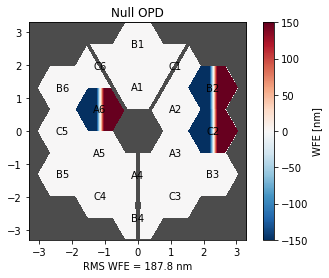

In [163]:
aber_wss_loop = np.zeros([nb_seg, 8])
noll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use
print('nm_aber:', nm_aber, 'nm')

# Apply aberration to all sgements
ote.reset()   # Making sure there are no previous movements on the segments.
ote.zero()    # For now, ignore internal WFE.
for i, nseg in enumerate(seg_array):
    aber_wss_loop[segnum_array[i], noll_as_wss[zern_pair-1]-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters

    # Put Zernike on correct segments on OTE
    ote._apply_hexikes_to_seg(nseg, aber_wss_loop[segnum_array[i],:])

# Display the OTE
ote.display_opd()
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


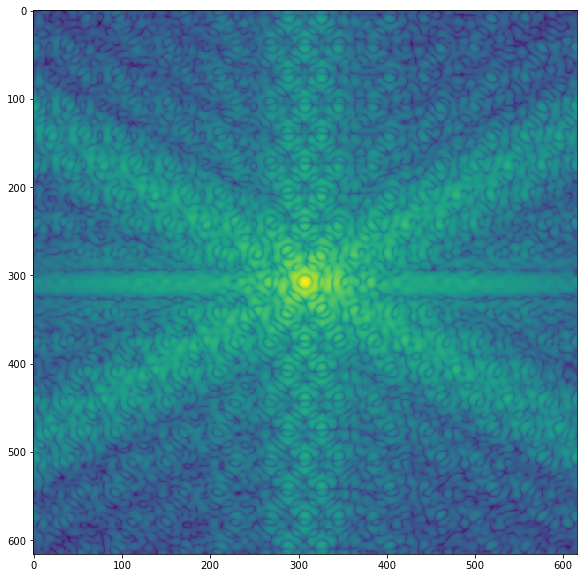

In [162]:
# Calculate the PSF
psf_zernpair= nc.calc_psf(fov_pixels=154, oversample=4, nlambda=1)   # oversampled for beeter seeign the fringes
psf_zernpair = psf_zernpair[0].data                                  # getting the oversampled extension
    
# Display the PSF
plt.figure(figsize=(10, 10))
plt.imshow(psf_zernpair, norm=LogNorm())   
plt.show()

I'm gonna stop here and go back to do the same thing with the analytical model in notebook 2. I am not sure the effect in the focal plane of me aberrating a pair of segments is really what it's supposed to be.

## WITH CORONAGRAPH

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


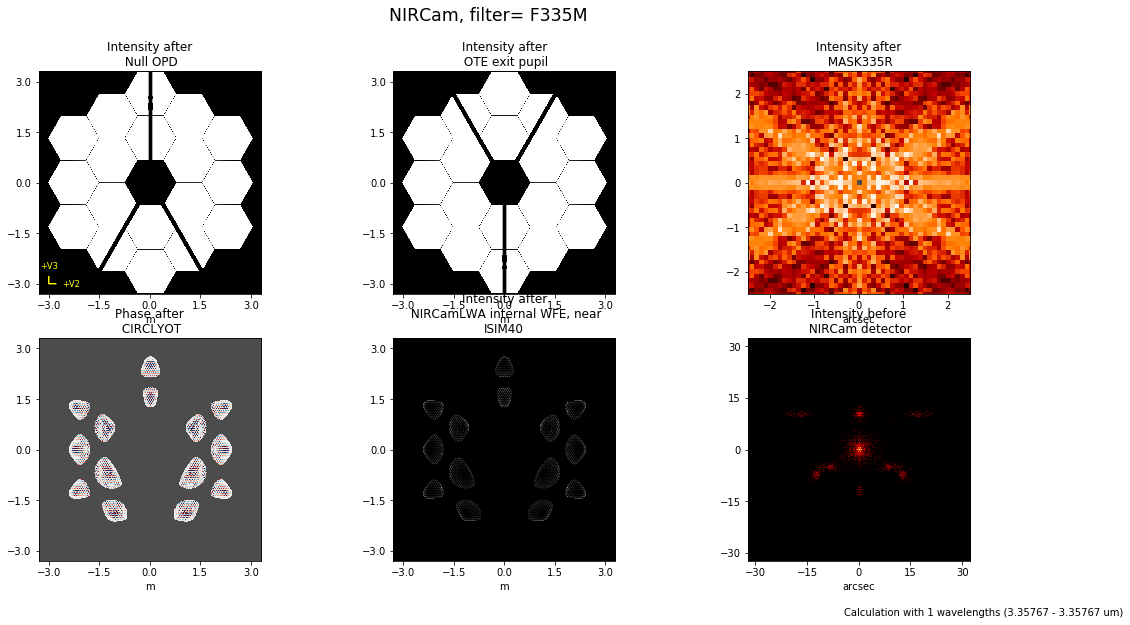

PSF calculation done


In [73]:
# Now add the coronagraph to nc_coro
nc_coro.image_mask = fpm
nc_coro.pupil_mask = lyot_stop

# And show what that looks like
plt.figure(figsize=(18, 9))
psf_coro = nc_coro.calc_psf(fov_pixels=im_size, oversample=1, nlambda=1, display=True)
plt.show()
psf_coro_im = psf_coro[1].data

print('PSF calculation done')

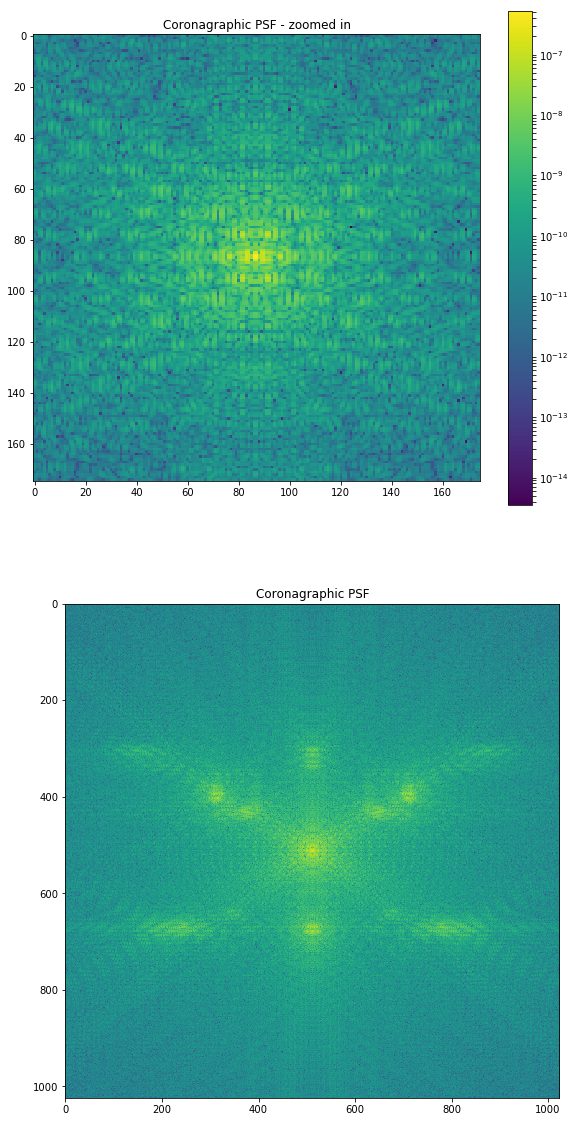

In [74]:
# I can't use webbpsf.display_psf(psf_coro) because I couldn't figure out how to change the color scaling
# and it turns out all black. So I'll just use matplotlib.
plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
plt.imshow(psf_coro_im[425:600, 425:600], norm=LogNorm())
plt.title('Coronagraphic PSF - zoomed in')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(psf_coro_im, norm=LogNorm())
plt.title('Coronagraphic PSF')
plt.show()

In [ ]:
# For comparison, the webbpsf display in physical units for the fov:
plt.figure(figsize=(10, 10))
webbpsf.display_psf(psf_coro, vmin=1e-19)
plt.show()

You can see that the coronagraphic PSF is not centro-symmetric, but it does have one symmetry axis. This is because of the weird symmetry of the lyot stop, which you can see above.